In [2]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.ticker as mticker
%matplotlib inline

import numpy as np
import pandas as pd

In [21]:
senn = pd.read_csv("gen/edit_success_20210527.13.05.1622147300_gpt2_gen_wikitext_split_epoch0_ts20000.2021-05-20_03-48-50")
enn = pd.read_csv("gen/edit_success_20210527.13.05.1622147247_gpt2_gen_wikitext_epoch0_ts20000.2021-05-20_15-47-26")

ewc = pd.read_csv("/juice/scr/em7/editable_transfer/clin/edit_success_20210526.17.05.1622075134_gpt2_gen_wikitext_ewc_epoch2_ts40000.2021-05-24_22-38-54-292116DolNw")
mmtm = pd.read_csv("/juice/scr/em7/editable_transfer/clin/edit_success_mmtm0.0005_20210526.20.05.1622086236_gpt2_epoch0_ts10000.20210408.09.04.1617899457")
finetune = pd.read_csv("/juice/scr/em7/editable_transfer/clin/edit_success_20210526.17.05.1622075282_gpt2_epoch0_ts10000.20210408.09.04.1617899457")


In [31]:
data = [
    {"data": enn, "opts": { "label": "ENN-1", "color": "black", "linewidth": 3} },
    {"data": senn, "opts": { "label": "PGP-3", "color": "red", "linewidth": 3} },
    {'data': ewc, "opts": { "label": "EWC", "color": "yellow", "linewidth": 3} },
#     {'data': mmtm, "opts": { "label": "MMTM 5e-4", "color": "blue", "linewidth": 3}},
    {'data': mmtm, "opts": { "label": "MMTM", "color": "blue", "linewidth": 3}},
    {'data': finetune, "opts": { "label": "GPT-2", "color": "gray", "linewidth": 3}}
]


In [32]:
spacing = 10
spacing_function = lambda x: int(x /spacing) * spacing
n_vis = 100

for d in data:
    d["data"]['grouping'] = d["data"].edit_number.apply(spacing_function)

In [33]:
# Plot config
# print(matplotlib.rcParams.keys())
matplotlib.rcParams["axes.titlesize"] = 20
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["legend.fontsize"] = 14

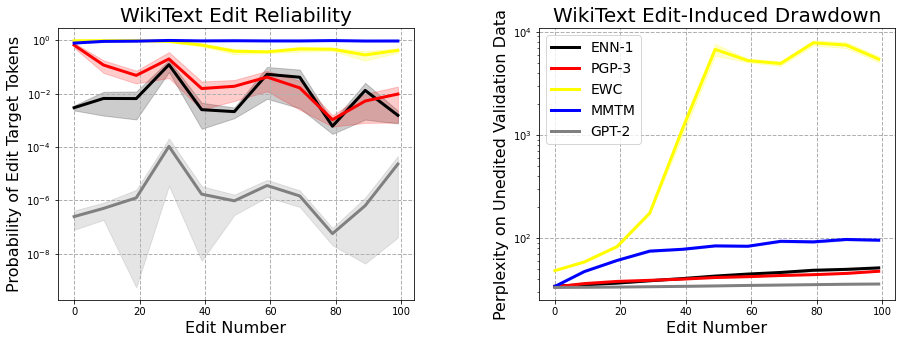

In [36]:
mean_exp = lambda x: np.mean(np.exp(x))
sem_exp = lambda x: np.exp(x).std() / x.shape[0]**0.5
sem_fn = lambda x: np.std(x) / x.shape[0]**0.5
def edit_metrics(frame):
    filter_query = f'edit_step == {frame.edit_step.max()} and edit_number < {n_vis} and (edit_number % 10 == 9 or edit_number == 0)'
    return (
        frame.query(filter_query).groupby("edit_number").logits.apply(mean_exp),
        frame.query(filter_query).groupby("edit_number").logits.apply(sem_exp)
    )

def drawdown_metrics(frame):
    return (
        frame.loc[~frame.new_ppl.isna()].groupby("edit_number").new_ppl.apply(np.mean),
        frame.loc[~frame.new_ppl.isna()].groupby("edit_number").new_ppl.apply(sem_fn)
    )

fig, ax = plt.subplots(1,2,figsize=(15,5))
for d in data:
    mean, sem = edit_metrics(d["data"])
    ax[0].plot(mean, **d["opts"])
    ax[0].fill_between(mean.index, mean-sem, mean+sem, color=d["opts"]["color"], alpha=0.2)

    mean, sem = drawdown_metrics(d["data"])
    ax[1].plot(mean, **d["opts"])
    ax[1].fill_between(mean.index, mean-sem, mean+sem, color=d["opts"]["color"], alpha=0.2)

ax[0].set_title("WikiText Edit Reliability")
ax[0].set_ylabel("Probability of Edit Target Tokens")
ax[0].set_xlabel("Edit Number")

ax[1].set_title("WikiText Edit-Induced Drawdown")
ax[1].set_ylabel("Perplexity on Unedited Validation Data")
ax[1].set_xlabel("Edit Number")


ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[1].legend()

ax[0].grid(linestyle="--", linewidth=1)
ax[1].grid(linestyle="--", linewidth=1)
plt.subplots_adjust(wspace=0.35)

plt.savefig('wikitext.pdf')